In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from matplotlib import pyplot as plt

In [2]:
from gpt.element import Lattice
from gpt.maps import Map25D_TM
from gpt.element import Screen
from gpt import GPT
from pmd_beamphysics import single_particle

from distgen.physical_constants import qe, c, MC2
import os

MC2=MC2.magnitude
c = c.magnitude

def p2e(p):
    p=np.array(p)
    return np.sqrt(p**2 + MC2**2)

def e2p(E):
    return np.sqrt(E**2-MC2**2)

def p2g(p):
    return np.sqrt((p/MC2)**2 - 1)

def p2b(p):
    return np.sqrt(1-1/p2g(p)**2)


In [32]:
lat = Lattice('Linac-Example')

lat.add(Map25D_TM('cav01', 'fields/7cell_2D.gdf', column_names=cnames, frequency=1.3e9, scale=6e6), ds=0)
lat.add(Map25D_TM('cav02', 'fields/7cell_2D.gdf', column_names=cnames, frequency=1.3e9, scale=6e6), ds=0.25)
lat.add(Map25D_TM('cav03', 'fields/7cell_2D.gdf', column_names=cnames, frequency=1.3e9, scale=6e6), ds=0.25)
lat.add(Map25D_TM('cav04', 'fields/7cell_2D.gdf', column_names=cnames, frequency=1.3e9, scale=6e6, relative_phase=-180), ds=0.25)
lat.add(Map25D_TM('cav05', 'fields/7cell_2D.gdf', column_names=cnames, frequency=1.3e9, scale=6e6, relative_phase=-180), ds=0.25)
lat.add(Map25D_TM('cav06', 'fields/7cell_2D.gdf', column_names=cnames, frequency=1.3e9, scale=6e6, relative_phase=-180), ds=0.25)

lat.add(Screen('scr'), ds=0.25)

end beg
woof


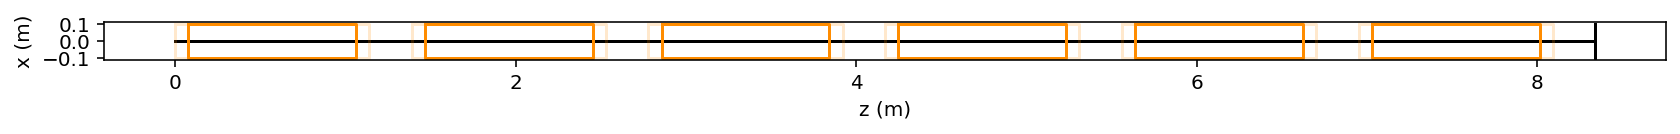

In [33]:
plt.figure(figsize=(14,5))
lat.plot_floor();

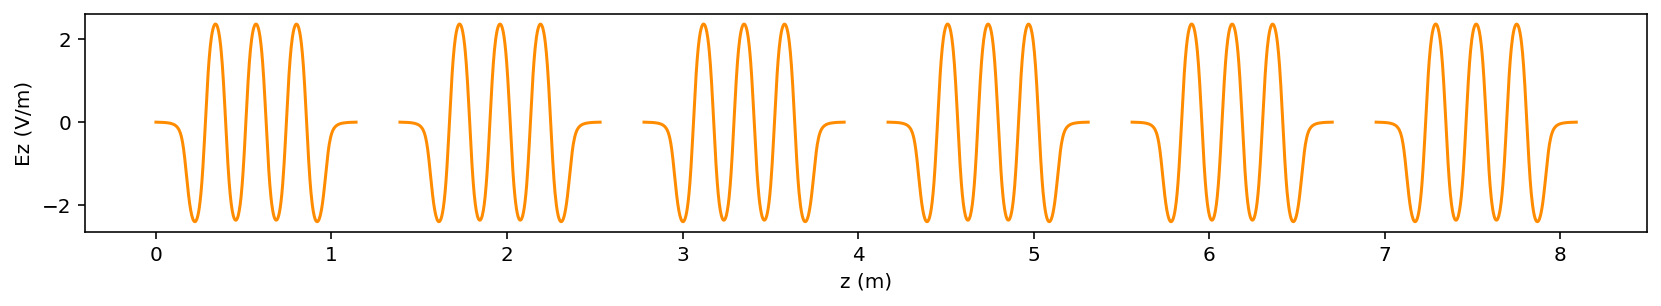

In [34]:
plt.figure(figsize=(14,2))
lat.plot_field_profile();

In [35]:
from gpt.autoscale import autophase1
from gpt.autoscale import autoscale1

In [36]:
%time ts, ps, zs, runs, G = autophase1(lat, 0, p=e2p(6e6)) 


> Phasing: cav01
   t_beg = 0 sec.
   s_beg = 0 m.
   scale = 6000000.0.
   relative phase = 0 deg.

   t_end = 3.816497034027416e-09 m.
   s_end = 1.14 m.
   oncrest phase = 42.492223054106034
   energy gain =  0.000 eV.

> Tracking: cav01:cav02
   energy gain: 0.0 eV.

> Phasing: cav02
   t_beg = 4.653448137980383e-09 sec.
   s_beg = 1.39 m.
   scale = 6000000.0.
   relative phase = 0 deg.

   t_end = 8.469945172007417e-09 m.
   s_end = 2.53 m.
   oncrest phase = 42.492223054106034
   energy gain =  0.000 eV.

> Tracking: cav02:cav03
   energy gain: 0.0 eV.

> Phasing: cav03
   t_beg = 9.306896275960376e-09 sec.
   s_beg = 2.78 m.
   scale = 6000000.0.
   relative phase = 0 deg.

   t_end = 1.3123393309987416e-08 m.
   s_end = 3.92 m.
   oncrest phase = 42.492223054106034
   energy gain =  0.000 eV.

> Tracking: cav03:cav04
   energy gain: 0.0 eV.

> Phasing: cav04
   t_beg = 1.3960344413943376e-08 sec.
   s_beg = 4.17 m.
   scale = 6000000.0.
   relative phase = -180 deg.

   t_end

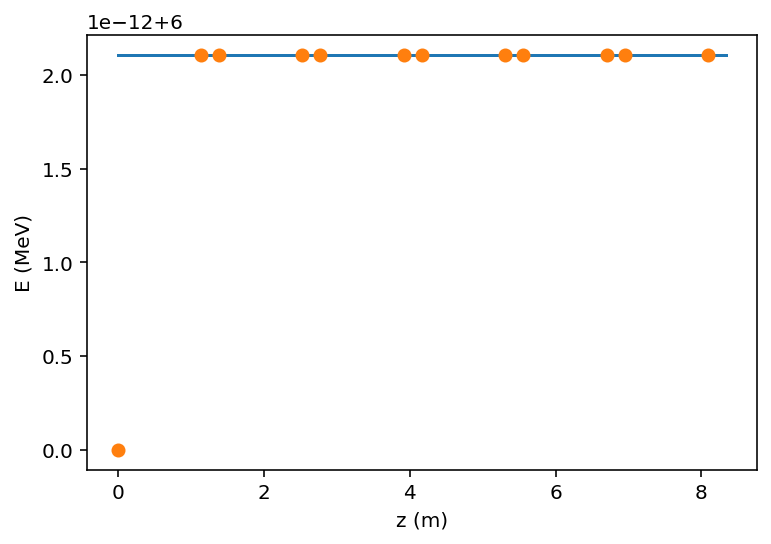

In [37]:
plt.plot(G.screen_stat('mean_z'), G.screen_stat('mean_energy')/1e6);
plt.plot(zs, p2e(ps)/1e6,'o');
plt.xlabel('z (m)');
plt.ylabel('E (MeV)');

In [41]:
GUN_FILE = os.path.abspath('fields/gun_0mm.gdf');
SOL1_FILE = os.path.abspath('fields/B_FIELD.gdf');
SOL2_FILE = os.path.abspath('fields/transport_sole_map.gdf');
CAV0_FILE = os.path.abspath('fields/197MHz.gdf');
CAV3_FILE = os.path.abspath('fields/591MHz.gdf');

f0 = 197e6
f3 = 591e6

from gpt.maps import Map2D_E
from gpt.maps import Map1D_B
from gpt.maps import Map1D_TM
from gpt.bstatic import Sectormagnet
from gpt.element import Screen

In [42]:
gun = Lattice('gun')
gun.add(Map2D_E('dcgun', GUN_FILE, scale=4/5), ds=0)
gun.add(Map1D_B('sol1', SOL1_FILE, scale=3.0), ds=0.33, ref_element='beg', element_origin='center')

tgun, pgun, zgun, sgun, rgun, Ggun = autoscale1(gun, t=0, p=100)

autoscale1: no cavities to phase

> Tracking: BEG:END
   energy gain: 399991.8381057344 eV.


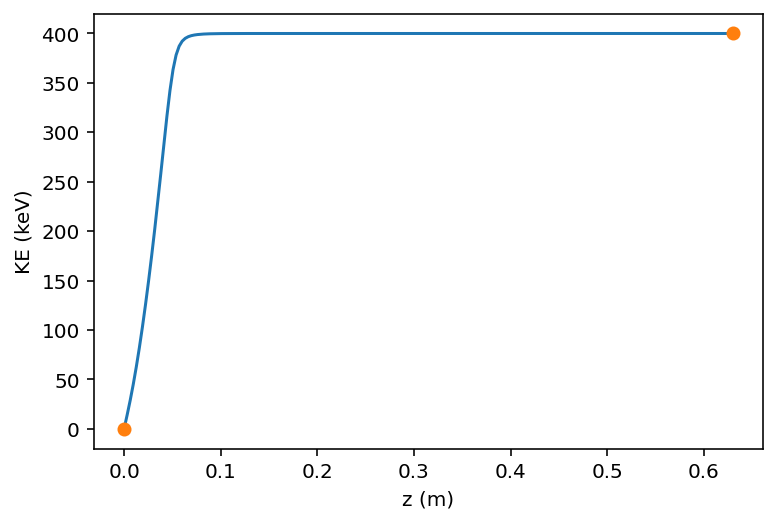

In [43]:
plt.plot(Ggun.screen_stat('mean_z'), Ggun.screen_stat('mean_kinetic_energy')/1e3);
plt.plot(sgun, (p2e(pgun)-MC2)/1000,'o');
plt.xlabel('z (m)');
plt.ylabel('KE (keV)');

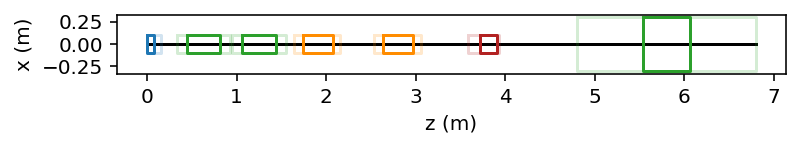

In [45]:
#------------------------------------------------------------------------------------------------
# Injector
#------------------------------------------------------------------------------------------------
injector = Lattice('injector')

gun_cnames={'R':'r', 'Z':'z', 'Er':'Er', 'Ez':'Ez', '|E|':'|E|', 'V':'V'}
injector.add(Map2D_E('dcgun', GUN_FILE, scale=4/5), ds=0)

injector.add(Map1D_B('sol1', SOL1_FILE, scale=3.0), ds=0.33, ref_element='beg')
injector.add(Map1D_B('sol2', SOL1_FILE, scale=2.0), ds=0.95, ref_element='beg')

injector.add(Map1D_TM('cav0', CAV0_FILE, frequency=f0, scale=2.0e6, relative_phase=0), ds=1.64, ref_element='beg')
injector.add(Map1D_TM('cav1', CAV0_FILE, frequency=f0, scale=2e6, relative_phase=0), ds=2.54, ref_element='beg')
injector.add(Map1D_TM('cav2', CAV3_FILE, frequency=f3, scale=(42/8/9)*1e6, color='firebrick', relative_phase=180), ds=3.5864, ref_element='beg')

injector.add(Map1D_B('sol3', SOL2_FILE, width=0.6, scale=3.0 ), ds=4.8, ref_element='beg')

injector.plot_floor();
    

In [46]:
%time ts, pins, zs, runs, Gin = autophase1(injector, 0, p=100 ,workdir='temp') 


> Tracking: BEG:cav0
   energy gain: 399991.8381057344 eV.

> Phasing: cav0
   t_beg = 6.780074062280517e-09 sec.
   s_beg = 1.64 m.
   scale = 2000000.0.
   relative phase = 0 deg.

   t_end = 8.677623848359557e-09 m.
   s_end = 2.16 m.
   oncrest phase = -14.5959418452494
   energy gain =  1993793.681 eV.

> Tracking: cav0:cav1
   energy gain: -3.526784309397045e-14 eV.

> Phasing: cav1
   t_beg = 9.965247741295658e-09 sec.
   s_beg = 2.54 m.
   scale = 2000000.0.
   relative phase = 0 deg.

   t_end = 1.1717732491761723e-08 m.
   s_end = 3.06 m.
   oncrest phase = 128.7837247539798
   energy gain =  1998976.682 eV.

> Tracking: cav1:cav2
   energy gain: -2.0701285670371452e-14 eV.

> Phasing: cav2
   t_beg = 1.3483225611705079e-08 sec.
   s_beg = 3.5864 m.
   scale = 583333.3333333334.
   relative phase = 180 deg.

   t_end = 1.4651094545586518e-08 m.
   s_end = 3.9343999999999997 m.
   oncrest phase = 49.06308952807365
   energy gain =  -539229.007 eV.

> Tracking: cav2:END
   ene

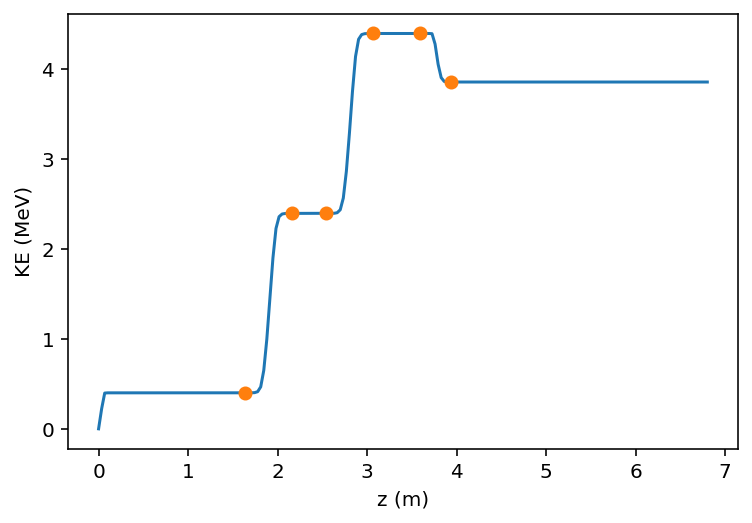

In [47]:
plt.plot(Gin.screen_stat('mean_z'), Gin.screen_stat('mean_kinetic_energy')/1e6);
plt.plot(zs, (p2e(pins)-MC2)/1e6,'o');
plt.xlabel('z (m)');
plt.ylabel('KE (MeV)');

In [ ]:
#------------------------------------------------------------------------------------------------
# Merger
#------------------------------------------------------------------------------------------------
p=pins[-1]

merger = Lattice('merger')

min_clearance = 0.0254     # [1"] meters
pipe_diameter = 2.0*0.0254 # [1"] meters

angle = -20
R = 0.8594366926962348
pipe_length=4.2

scale = 1

merger.add(Sectormagnet('b1', R, +angle, p, phi_in=np.abs(angle/4), phi_out=np.abs(angle/4), gap=0.05, fix=True), ds=0.25)
#merger.add(Sectormagnet('b2', R, -angle, p, phi_in=np.abs(angle/4), phi_out=np.abs(angle/4), gap=0.05, fix=True), ds=pipe_length)

merger.add(Map1D_B('sol4', SOL2_FILE, column_names={'z':'z', 'Bz':'Bz'}, width=0.6, scale=+scale, field_pos='center'), ds=1.05, ref_element='b1', element_origin='center')
#merger.add(Map1D_B('sol5', SOL2_FILE, column_names={'z':'z', 'Bz':'Bz'}, width=0.6, scale=-scale, field_pos='center'), ds=3.15, ref_element='b1', element_origin='center')
merger.add(Screen('scr1'), ref_element='b1', ds=2.1)
#merger.add(Screen('scr2'), ds=0.05)
    
merger.plot_floor();

In [ ]:
in2merge = injector + merger

%time t1, p1, z1, s1, r1, G1 = autoscale1(in2merge, 0, p=100, workdir='temp') 

In [ ]:
plt.plot(Gin.tout_ccs_stat('mean_z'), Gin.tout_ccs_stat('mean_kinetic_energy')/1e6);
#plt.plot(ss, (p2e(pins)-MC2)/1e6,'o');
plt.xlabel('z (m)');
plt.ylabel('KE (MeV)');

In [ ]:
#------------------------------------------------------------------------------------------------
# Linac
#------------------------------------------------------------------------------------------------
    
energy_gain = 13.6e6-p2e(pins[-1])   

scale3 = energy_gain/9
scale1 = (energy_gain + scale3)/8
    
linac = Lattice('linac')             
             
linac.add(Map1D_TM('cav04', CAV0_FILE, frequency=f0, scale=scale1), ds=2)
linac.add(Map1D_TM('cav05', CAV0_FILE, frequency=f0, scale=scale1), ds=1.05)
linac.add(Map1D_TM('cav06', CAV0_FILE, frequency=f0, scale=scale1), ds=1.02)
linac.add(Map1D_TM('cav07', CAV0_FILE, frequency=f0, scale=scale1), ds=1.05)

linac.add(Map1D_TM('cav08', 
                   CAV3_FILE, 
                   frequency=f3, 
                   color='firebrick',
                   scale=scale3,
                   relative_phase=180), 
          ds=3.81715)

linac.add(Map1D_TM('cav09', CAV0_FILE, frequency=f0, scale=scale1), ds=3.31715)
linac.add(Map1D_TM('cav10', CAV0_FILE, frequency=f0, scale=scale1), ds=1.05)
linac.add(Map1D_TM('cav11', CAV0_FILE, frequency=f0, scale=scale1), ds=1.02)
linac.add(Map1D_TM('cav12', CAV0_FILE, frequency=f0, scale=scale1), ds=1.05)
linac.add(Screen('scr3'), ds=1.0)

plt.figure(figsize=(15,4));
linac.plot_floor();

In [ ]:
%time ts, ps, zs, runs, G = autophase1(linac, 0, p=pins[-1]) 

In [ ]:
plt.plot(G.screen_stat('mean_z'), G.screen_stat('mean_energy')/1e6);
plt.plot(zs, p2e(ps)/1e6,'o');
plt.xlabel('z (m)');
plt.ylabel('E (MeV)');

In [ ]:
lat = injector + merger + linac

In [ ]:
# Check that phasing works on simple lattice with no bends:

from gpt.autoscale import autophase12
%time t1, p1, z1, run1, G1 = autophase12(injector, t=0, p=100)